# Binary Segmentation: PyTorch version
One wants to optimize the Jaccard index of the foreground class.
One can use either the Lovász Hinge or the Lovász-Sigmoid for binary problems.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function

In [3]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn

In [4]:
import lovasz_losses as L

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
%matplotlib inline

In [6]:
from tqdm import tqdm_notebook as tqdm

In [7]:
# add parent path to pythonpath to import demo_utils
import sys
sys.path.append('../demo_helpers')

def pil(array):
    im = Image.fromarray(array)
    im.putpalette(paletteVOC(PIL=True))
    return im


def pil_grid(images, max_horiz=np.iinfo(int).max, margin=0, background='white'):
    """
    Grid of images in PIL
    """
    n_images = len(images)
    n_horiz = min(n_images, max_horiz)
    h_sizes, v_sizes = [0] * n_horiz, [0] * (n_images // n_horiz)
    for i, im in enumerate(images):
        h, v = i % n_horiz, i // n_horiz
        h_sizes[h] = max(h_sizes[h], im.size[0]) + margin
        v_sizes[v] = max(v_sizes[v], im.size[1]) + margin
    h_sizes, v_sizes = np.cumsum([0] + h_sizes), np.cumsum([0] + v_sizes)
    im_grid = Image.new('RGB', (h_sizes[-1], v_sizes[-1]), color=background)
    for i, im in enumerate(images):
        im_grid.paste(im, (h_sizes[i % n_horiz], v_sizes[i // n_horiz]))
    return im_grid


def dummy_triangles(w, categories=[0, 255, 1]):
    """
    Generate random images with desired categories and random triangles
    """
    im = Image.new('P', (w, w), color=categories[0])
    im.putpalette(paletteVOC(PIL=True))
    draw = ImageDraw.Draw(im)
    for c in categories[1:]:
        draw.polygon([tuple(p) for p in np.random.randint(w, size=(3, 2))], fill=c, outline=None)
    return im

def paletteVOC(N=256, normalized=False, PIL=False):
    """
    Pascal VOC color map
    """
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    if PIL:
        cmap = [k for l in cmap for k in l]
    return cmap



In [17]:
CUDA = False

In [18]:
def cuda(x):
    if CUDA:
        return x.cuda(3)
    else:
        return x

## Batch of 10 random images with background (0), foreground (1), void (255) class

### Labels

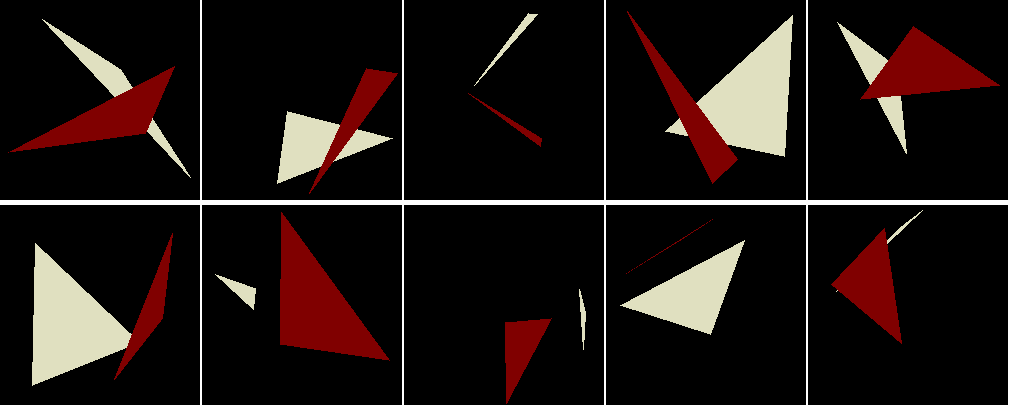

In [19]:
np.random.seed(18)
labels_ = [dummy_triangles(200, [0, 255, 1]) for b in range(10)]
labels = torch.stack([torch.from_numpy(a) for a in map(np.array, labels_)]).long()
pil_grid(labels_, 5, margin=1)

### Features

In [32]:
np.random.seed(57)
feats = labels.float()
feats[labels == 0] = feats[labels == 0].normal_(-1, 2.5)
feats[labels == 1] = feats[labels == 1].normal_(1, 2.5)
feats[labels == 255] = feats[labels == 255].normal_(0, 5)

In [33]:
feats = Variable(cuda(feats))
labels = cuda(labels)

## Model

In [34]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bias = nn.Parameter(torch.Tensor([0]))
        
    def forward(self, x):
        return x + self.bias
    
m = Model()

In [35]:
m = cuda(m)

### Initial prediction

In [36]:
preds = (m(feats) > 0).long().data
print("Initial image-IoU:", L.iou_binary(preds, labels, ignore=255, per_image=False))

Initial image-IoU: 0.132920054200542


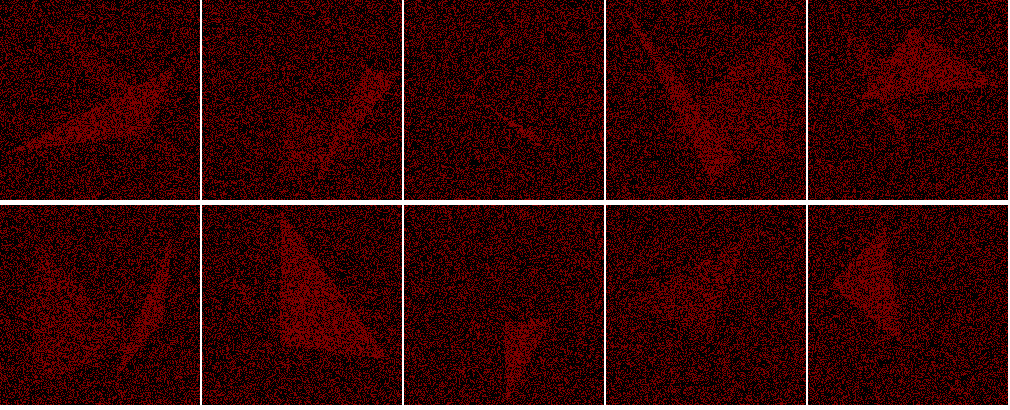

In [40]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

## Lovász hinge training

In [44]:
m.bias.data.fill_(0) # reset b

optimizer = Adam(m.parameters(), lr=0.05)

loss_plot = []
iou_plot = []

for iter in tqdm(range(500)):
    optimizer.zero_grad()
    out = m(feats)
    print(out[1])
    print(labels.shape)
    loss = L.lovasz_hinge(out, labels, ignore=255)
    loss.backward()
    optimizer.step()
    
    preds = (out.data > 0).long()
    loss_plot.append(loss.item())
    iou_plot.append(L.iou_binary(preds, labels, ignore=255, per_image=True))

tensor([[-3.8981, -3.0116, -2.8026,  ..., -2.6194, -3.4011,  1.9103],
        [-7.5228, -6.6651,  6.1581,  ..., -2.3568, -1.9422, -5.0255],
        [ 2.2961, -1.2770, -1.1618,  ...,  1.1170, -0.4582, -0.9857],
        ...,
        [ 1.4518, -2.6386, -1.7583,  ..., -0.1525,  0.9158,  3.0486],
        [-4.1644, -2.3493,  0.4595,  ..., -3.9919, -0.4833, -0.7811],
        [-0.8213,  1.1524, -2.0038,  ...,  0.1869, -2.6047, -0.2034]],
       grad_fn=<SelectBackward>)
torch.Size([10, 200, 200])



RuntimeError: Expected object of type torch.LongTensor but found type torch.FloatTensor for argument #3 'other'

In [ ]:
L.lovasz_hinge(out, labels, ignore=255, per_image=True)

In [ ]:
plt.figure(figsize=(10, 5))
plt.suptitle(u'Lovász hinge training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration');

### Final prediction

In [ ]:
preds = (m(feats) > 0).long().data
print("Final image-IoU:", L.iou_binary(preds, labels, ignore=255, per_image=True))

In [ ]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

## Lovász-Sigmoid training

In [ ]:
m.bias.data.fill_(0) # reset b

optimizer = Adam(m.parameters(), lr=0.05)

loss_plot_x = []
iou_plot_x = []

for iter in tqdm(range(500)):
    optimizer.zero_grad()
    logits = m(feats)
    out = torch.sigmoid(logits)
    loss = L.lovasz_softmax(out, labels, classes=[1], ignore=255)
    loss.backward()
    optimizer.step()
    
    preds = (logits.data > 0).long()
    loss_plot_x.append(loss.item())
    iou_plot_x.append(L.iou_binary(preds, labels, ignore=255, per_image=True))

In [ ]:
plt.figure(figsize=(10, 5))
plt.suptitle(u'Lovász-Sigmoid training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot_x)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot_x)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration')

### Final prediction

In [ ]:
preds = (m(feats) > 0).long().data
print("Final image-IoU:", L.iou_binary(preds, labels, ignore=255, per_image=True))

In [ ]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

## Binary cross-entropy training

In [ ]:
m.bias.data.fill_(0) # reset b

optimizer = Adam(m.parameters(), lr=0.05)

loss_plot_x = []
iou_plot_x = []

for iter in tqdm(range(500)):
    optimizer.zero_grad()
    out = m(feats)
    loss = L.binary_xloss(out, labels, ignore=255)
    loss.backward()
    optimizer.step()
    
    preds = (out.data > 0).long()
    loss_plot_x.append(loss.item())
    iou_plot_x.append(L.iou_binary(preds, labels, ignore=255, per_image=True))

In [ ]:
plt.figure(figsize=(10, 5))
plt.suptitle(u'Binary cross-entropy training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot_x)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot_x)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration')

### Final prediction

In [ ]:
preds = (m(feats) > 0).long().data
print("Final image-IoU:", L.iou_binary(preds, labels, ignore=255, per_image=True))

In [ ]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)